/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[1] loss: 2.841


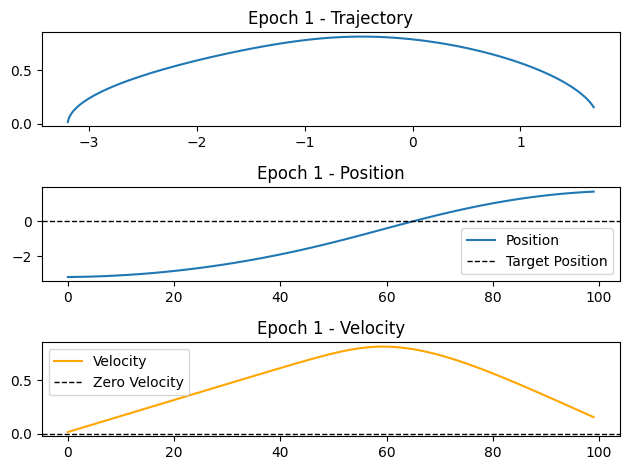

[2] loss: 0.933


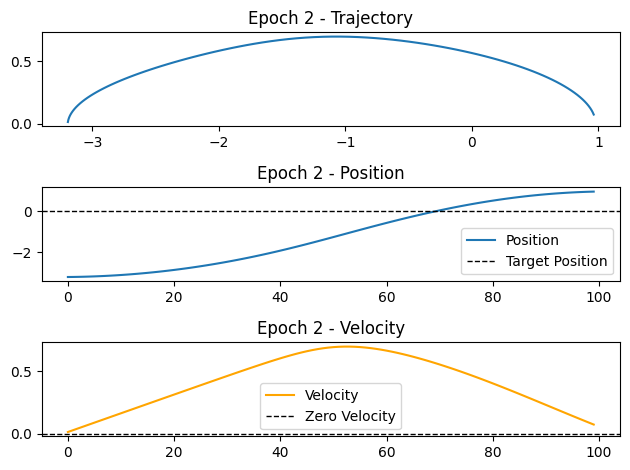

[3] loss: 0.285


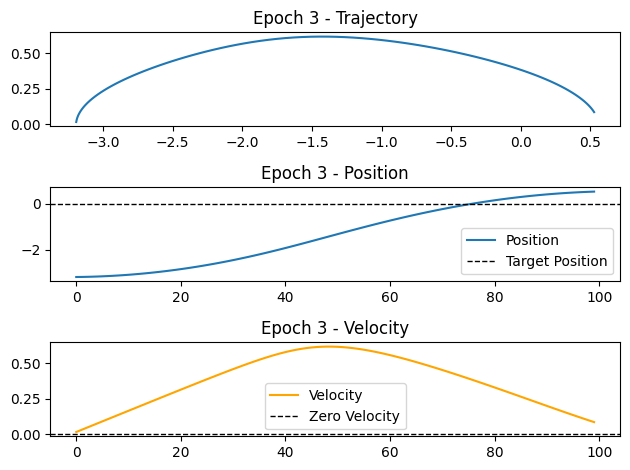

[4] loss: 0.121


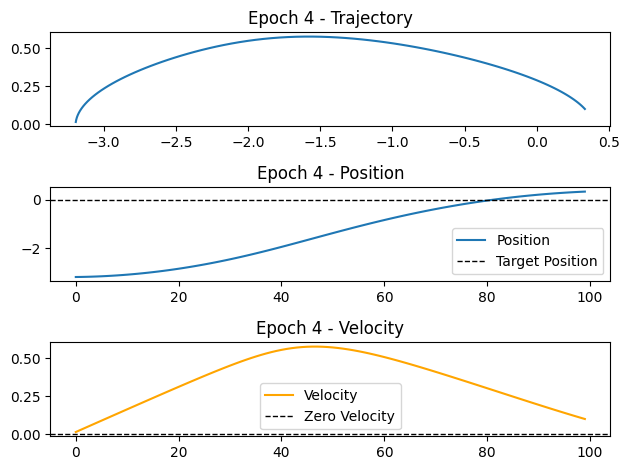

[5] loss: 0.067


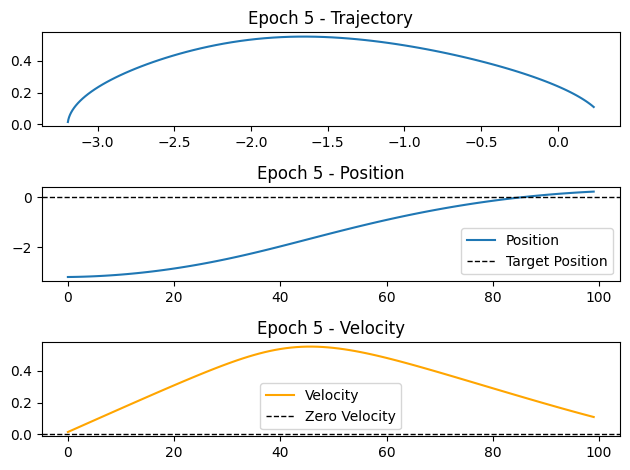

[6] loss: 0.044


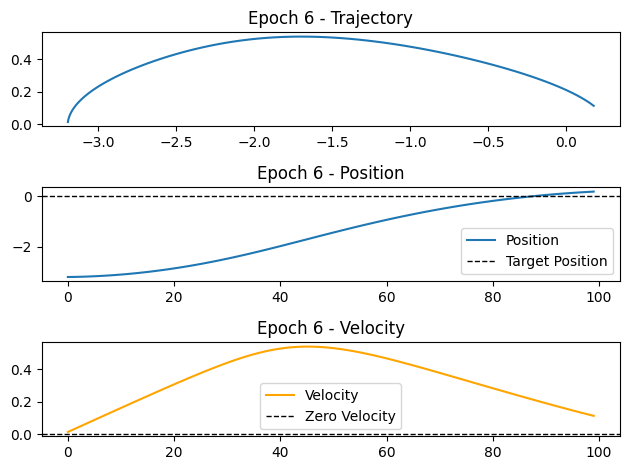

[7] loss: 0.032


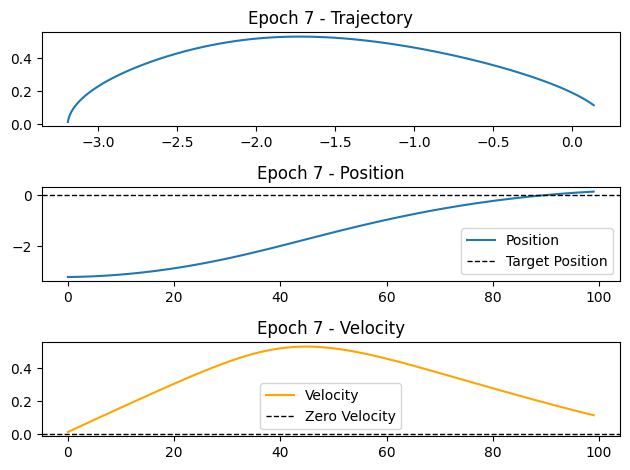

[8] loss: 0.025


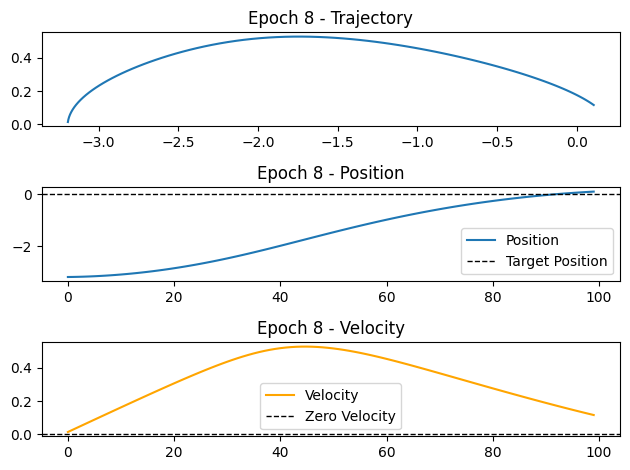

[9] loss: 0.020


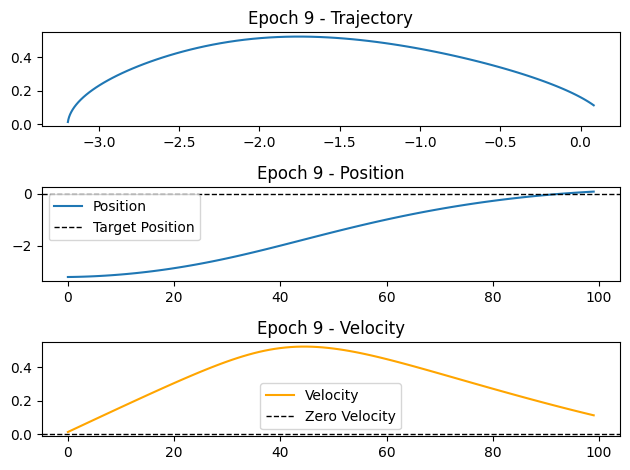

[10] loss: 0.015


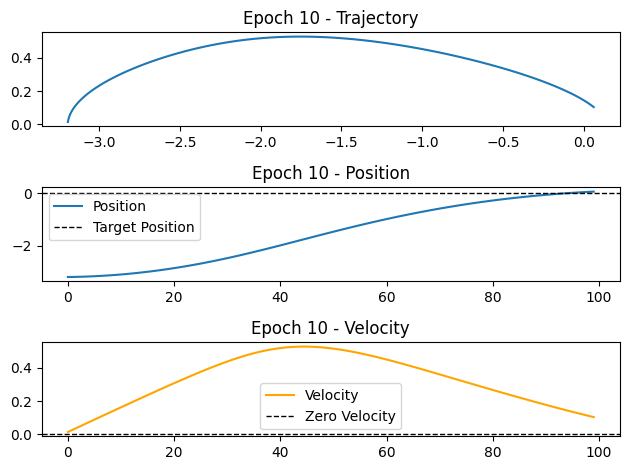

[11] loss: 0.009


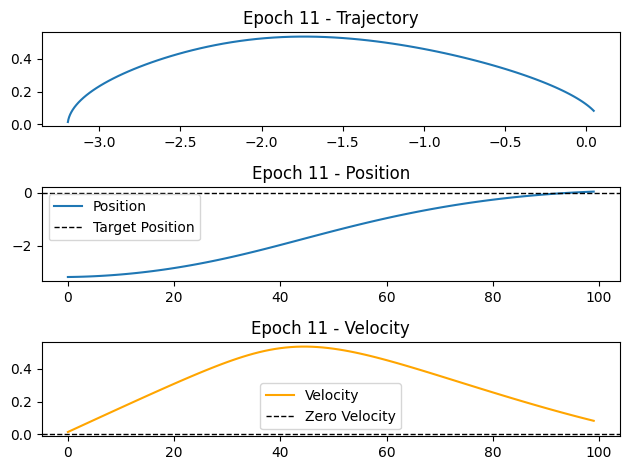

[12] loss: 0.005


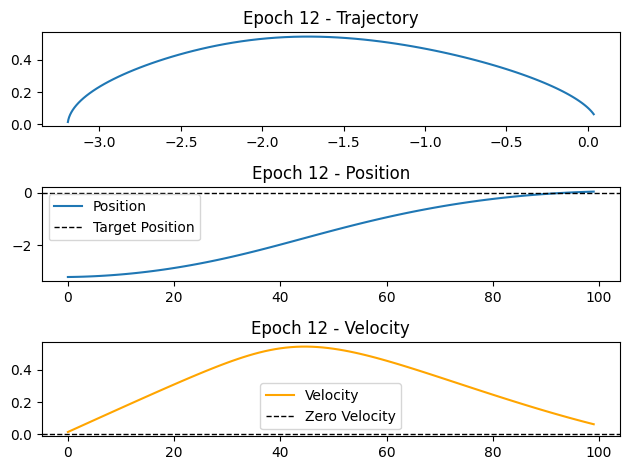

[13] loss: 0.003


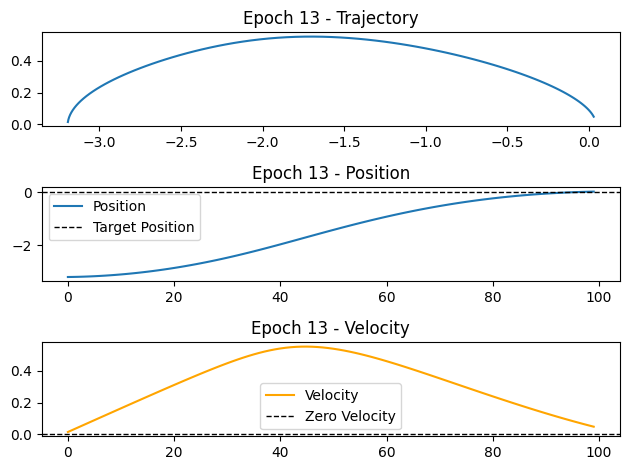

[14] loss: 0.002


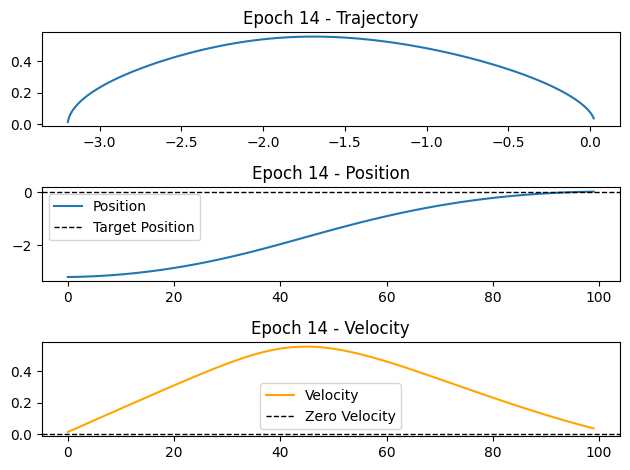

[15] loss: 0.001


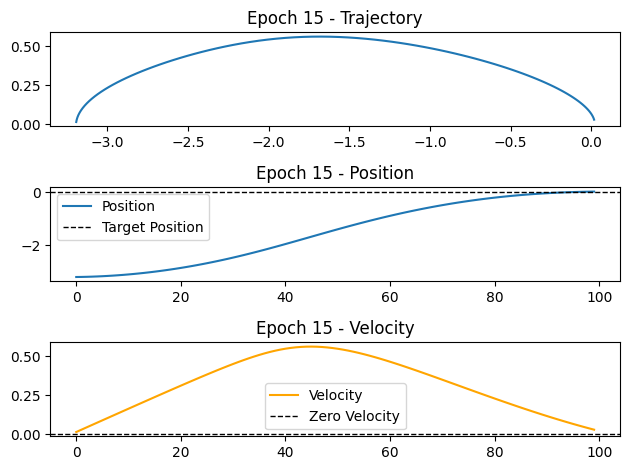

[16] loss: 0.001


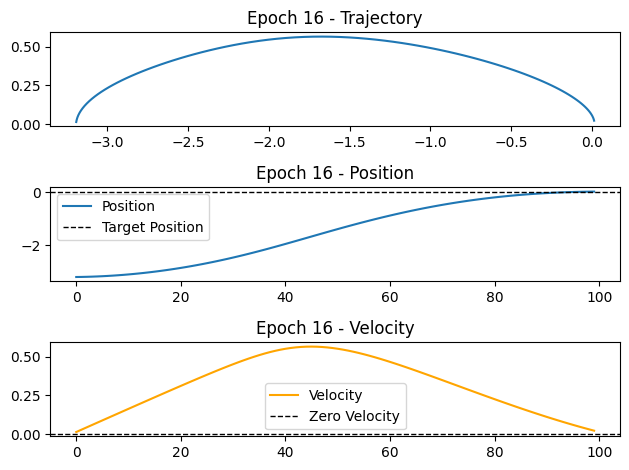

[17] loss: 0.000


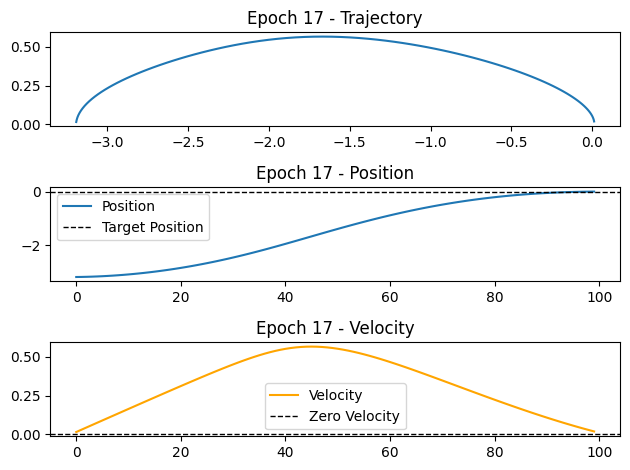

[18] loss: 0.000


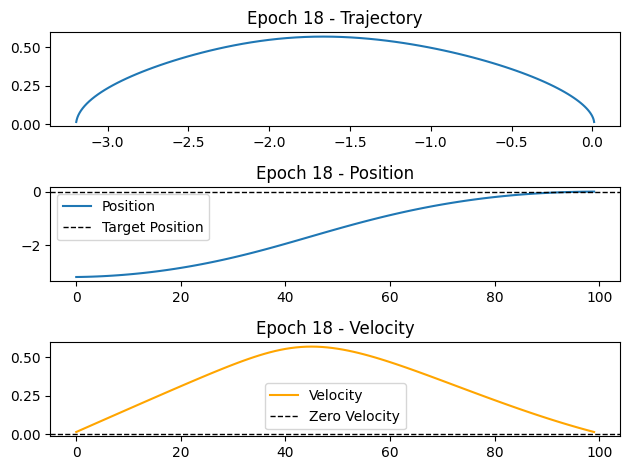

[19] loss: 0.000


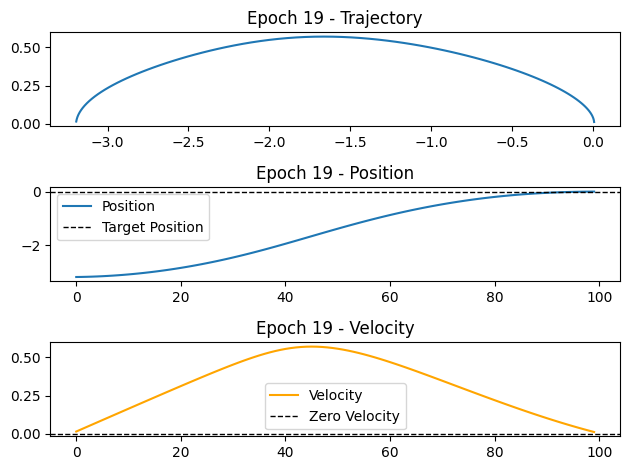

[20] loss: 0.000


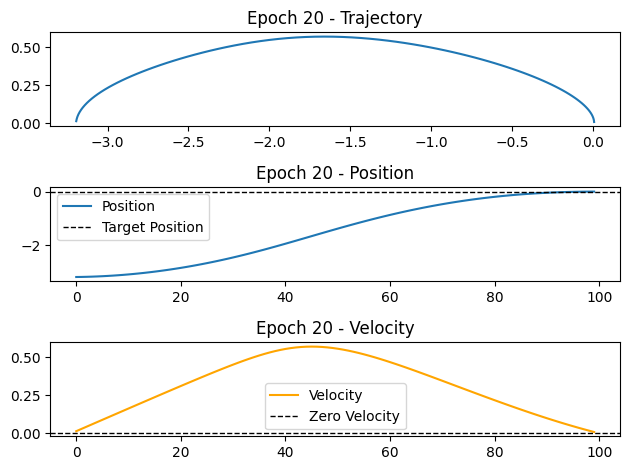

[21] loss: 0.000


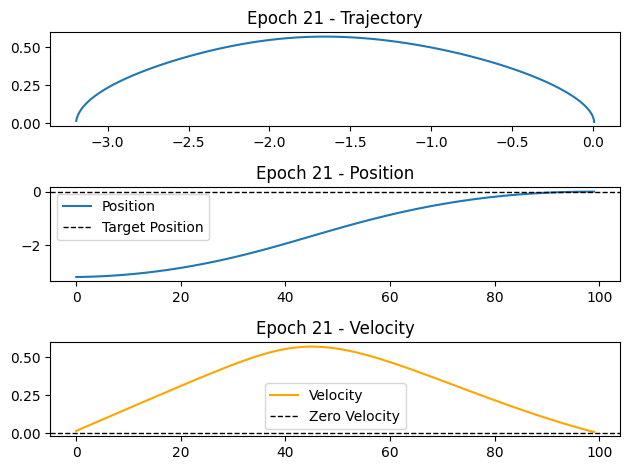

[22] loss: 0.000


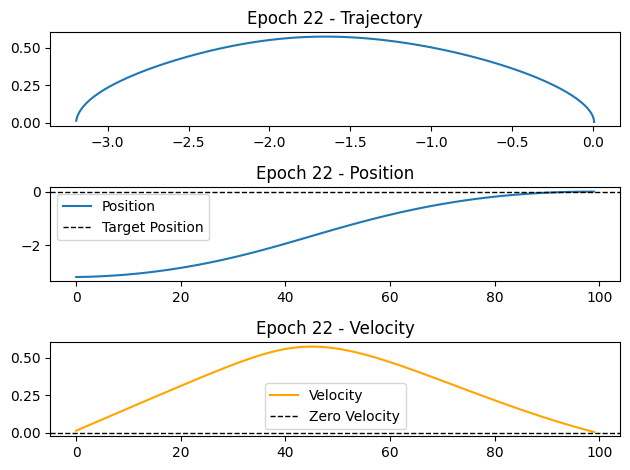

[23] loss: 0.000


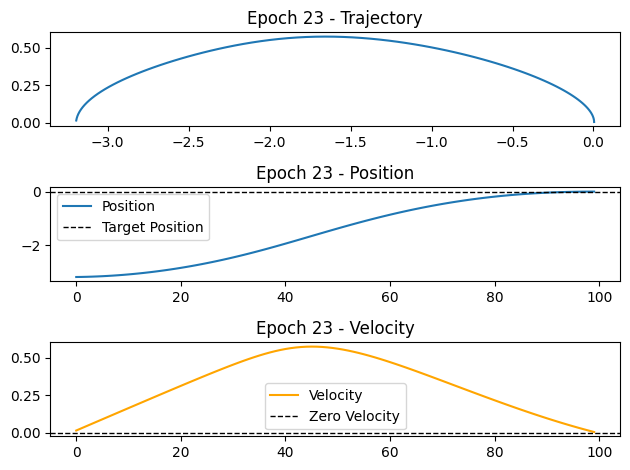

[24] loss: 0.000


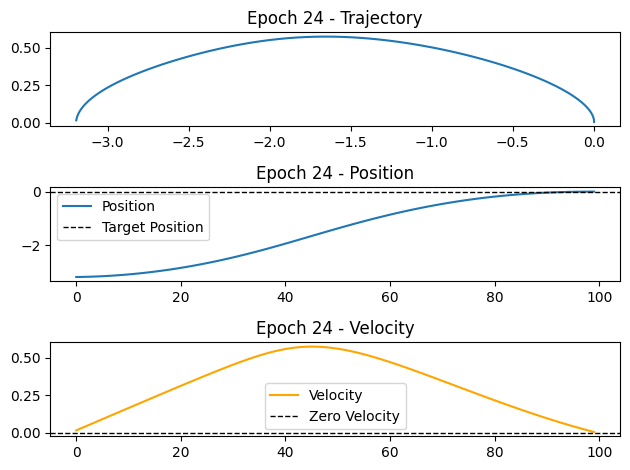

[25] loss: 0.000


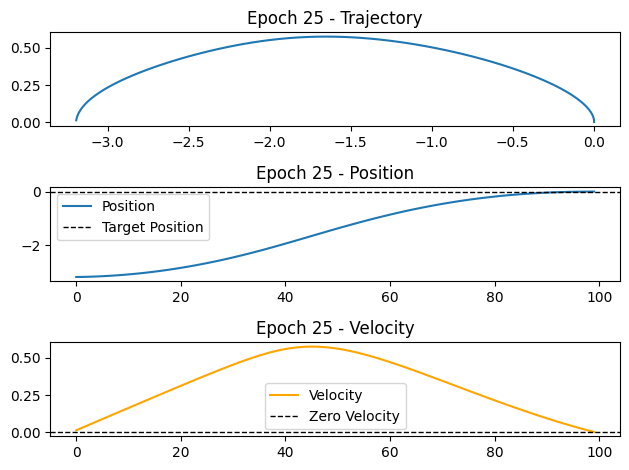

[26] loss: 0.000


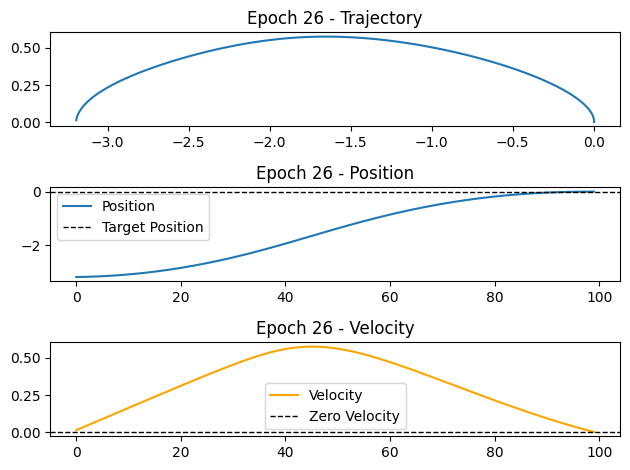

[27] loss: 0.000


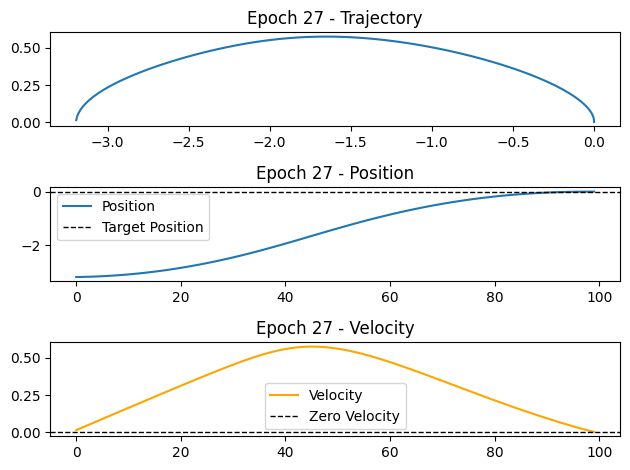

[28] loss: 0.000


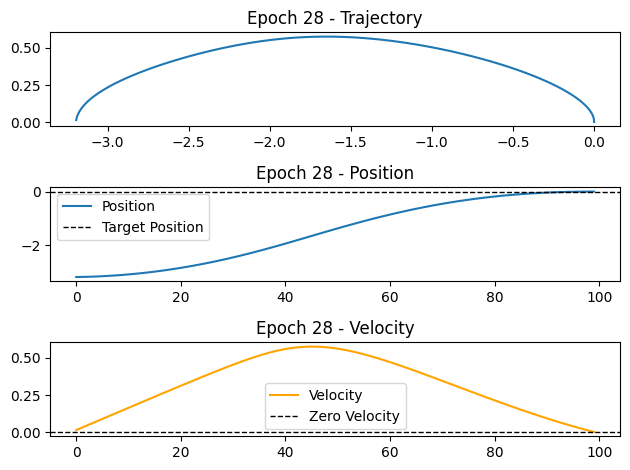

[29] loss: 0.000


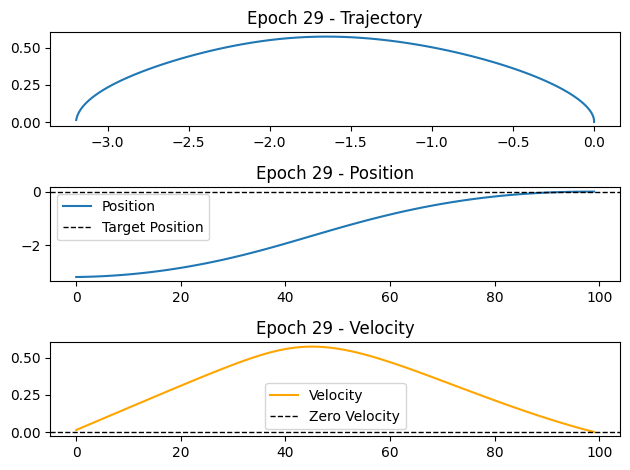

[30] loss: 0.000


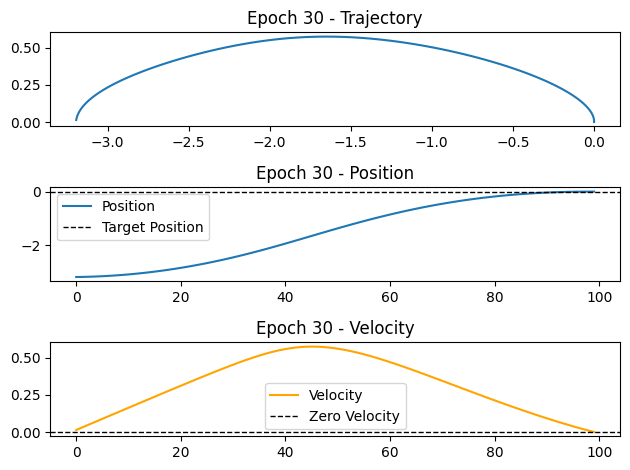

[31] loss: 0.000


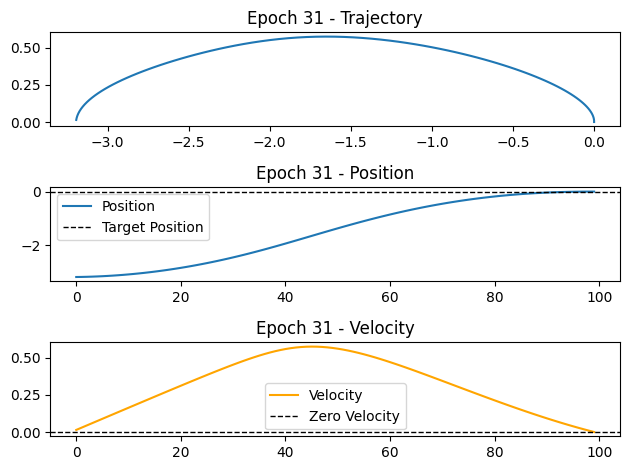

[32] loss: 0.000


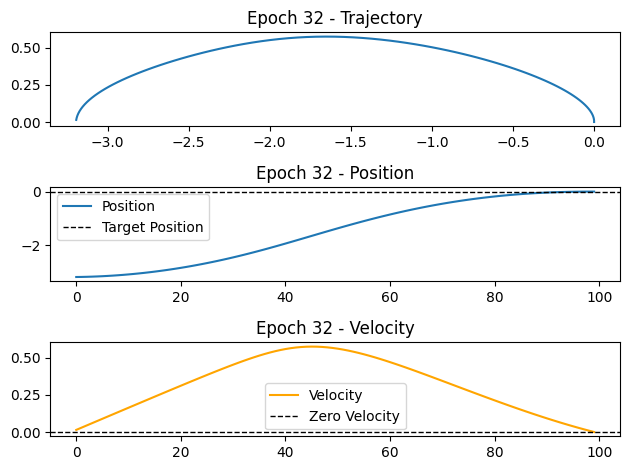

[33] loss: 0.000


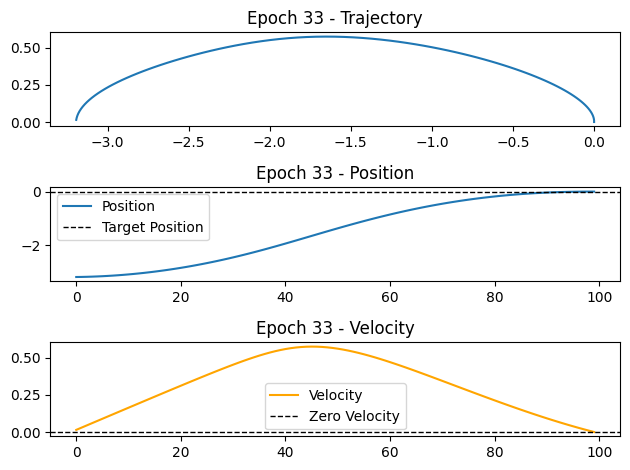

[34] loss: 0.000


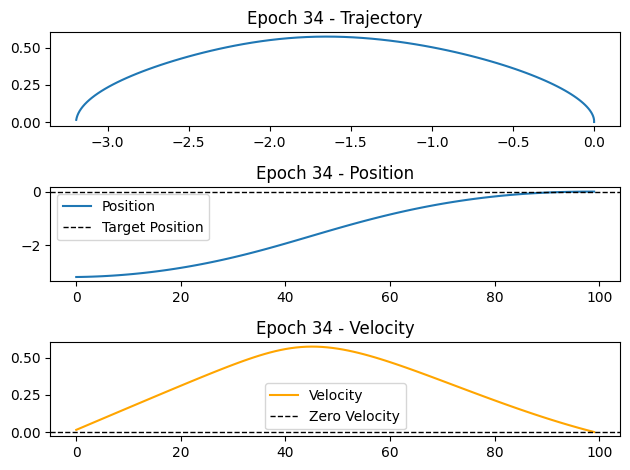

[35] loss: 0.000


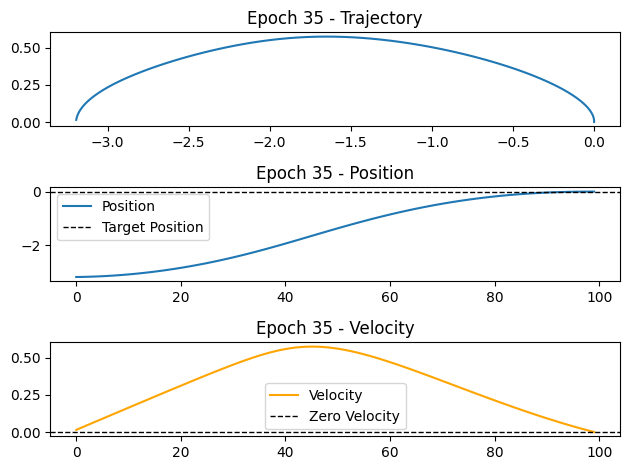

[36] loss: 0.000


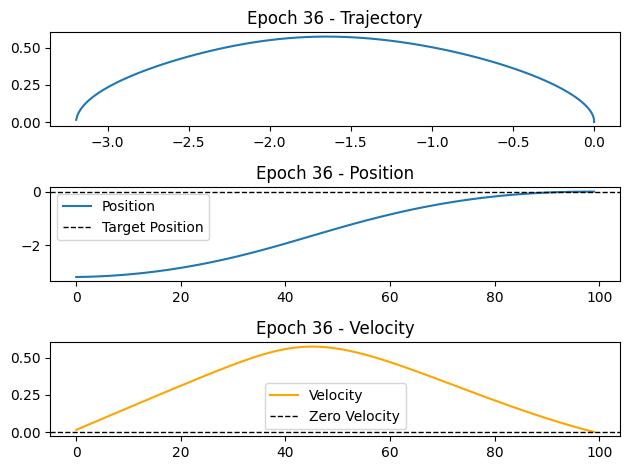

[37] loss: 0.000


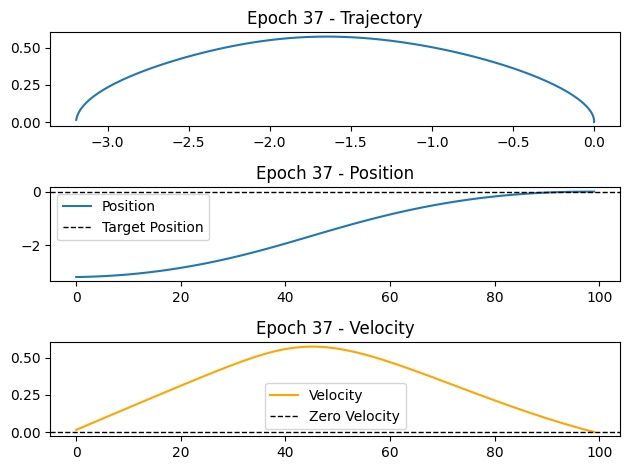

[38] loss: 0.000


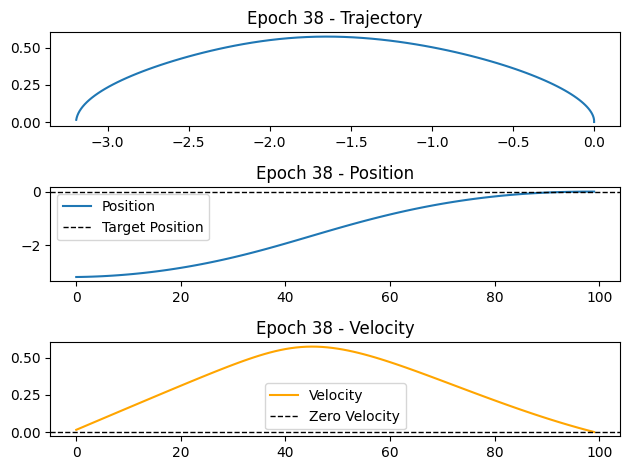

[39] loss: 0.000


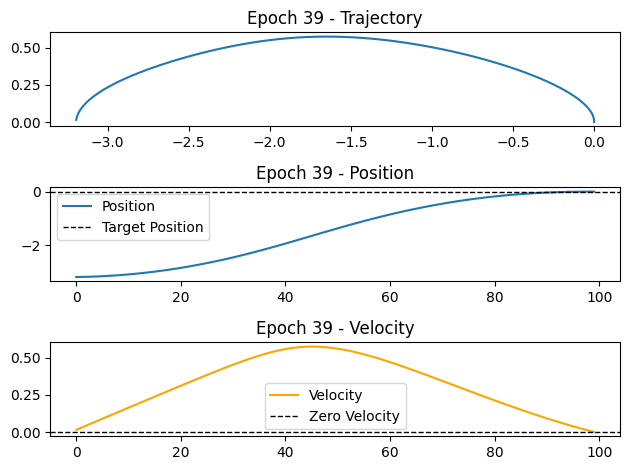

[40] loss: 0.000


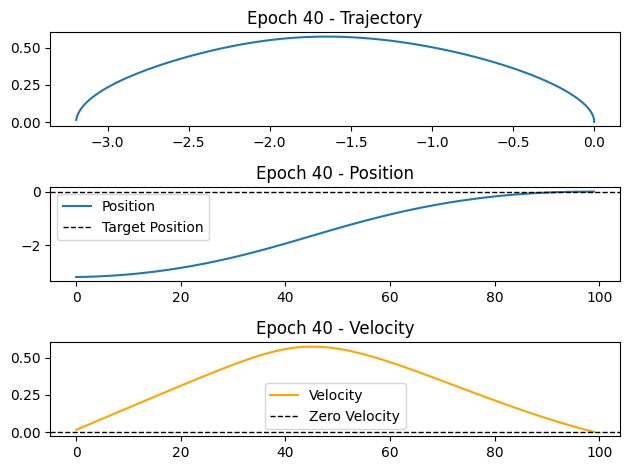

In [ ]:
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt

# Setup logging
logger = logging.getLogger(__name__)

# Environment parameters
FRAME_TIME = 0.1  # Time interval
FRICTION_ACCEL = 0.05  # Friction constant
MAX_ACCELERATION = 0.2  # Maximum acceleration

class Dynamics(nn.Module):
    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):
        """
        Dynamics of the self-parking car.

        Args:
            state (tensor): Current state [x, v]
            action (tensor): Acceleration

        Returns:
            tensor: Updated state [x, v]
        """
        # Apply friction
        delta_state_friction = t.tensor([0., -FRICTION_ACCEL * FRAME_TIME])

        # Acceleration
        delta_state = action * FRAME_TIME * t.tensor([0, -1]) * MAX_ACCELERATION

        # Update velocity and position
        state = state + delta_state + delta_state_friction

        # Update state
        step_mat = t.tensor([[1., FRAME_TIME],
                            [0., 1.]])
        state = t.matmul(step_mat, state)

        return state

class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        Controller for the self-parking car.

        Args:
            dim_input (int): Number of system states
            dim_output (int): Number of actions
            dim_hidden (int): Number of hidden units
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Tanh()  # Adjust activation function based on the problem
        )

    def forward(self, state):
        """
        Forward pass through the controller.

        Args:
            state (tensor): Current state [x, v]

        Returns:
            tensor: Acceleration
        """
        action = self.network(state)
        return action

class Simulation(nn.Module):
    def __init__(self, controller, dynamics, T):
        """
        Simulation class for the self-parking car.

        Args:
            controller (nn.Module): Controller module
            dynamics (nn.Module): Dynamics module
            T (int): Number of time steps
        """
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        """
        Forward pass through the simulation.

        Args:
            state (tensor): Initial state [x, v]

        Returns:
            tensor: Error value
        """
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(self.T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        """
        Initialize the initial state of the self-parking car.

        Returns:
            tensor: Random initial state within a reasonable range [x, v]
        """
        state = [random.uniform(-10, 10), 0.]
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        """
        Calculate the error for the self-parking car.

        Args:
            state (tensor): Current state [x, v]

        Returns:
            tensor: Error value
        """
        # Minimize distance from the target (e.g., parking spot at x=0)
        target_position = 0
        return (state[0] - target_position)**2 + state[1]**2

class Optimize:
    def __init__(self, simulation):
        """
        Optimizer class for the self-parking car.

        Args:
            simulation (nn.Module): Simulation module
        """
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        """
        Perform one optimization step.

        Returns:
            tensor: Loss value
        """
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()

    def train(self, epochs):
        """
        Train the optimizer over multiple epochs.

        Args:
            epochs (int): Number of training epochs
        """
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize(epoch + 1)

    def visualize(self, epoch):
        """
        Visualize the trajectory, position, and velocity.

        Args:
            epoch (int): Current epoch
        """
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]

        # Plot trajectory
        plt.subplot(3, 1, 1)
        plt.plot(x, y)
        plt.title(f'Epoch {epoch} - Trajectory')

        # Plot position
        plt.subplot(3, 1, 2)
        plt.plot(x, label='Position')
        plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Target Position')
        plt.title(f'Epoch {epoch} - Position')
        plt.legend()

        # Plot velocity
        plt.subplot(3, 1, 3)
        velocity = data[:, 1]
        plt.plot(velocity, label='Velocity', color='orange')
        plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Zero Velocity')
        plt.title(f'Epoch {epoch} - Velocity')
        plt.legend()

        plt.tight_layout()
        plt.show()

# Now it's time to run the code!
T = 100  # Number of time steps
dim_input = 2  # State space dimensions (position, velocity)
dim_hidden = 6  # Latent dimensions
dim_output = 1  # Action space dimensions (acceleration)
d = Dynamics()  # Define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # Define controller
s = Simulation(c, d, T)  # Define simulation
o = Optimize(s)  # Define optimizer
o.train(40)  # Solve the optimization problem


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c322c12c-9c89-40a1-919f-19d8af38eaf4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>